In [3]:
import sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

PACKAGEDIR = Path('/scistor/ivm/jsn295/Weave')
sys.path.append(str(PACKAGEDIR))
from Weave.inputoutput import Reader

### Small investigation of a single importance set

In [2]:
# All importances are mean_absolute_error
# Scaling the scores to 1 before group averaging? Scores in one fold are not comparable to other folds.
testpath = '/scistor/ivm/jsn295/importance/1/-3/responsagg_separation.parquet'

In [1]:
def scale_scores_ranks_to_importance(df, fill_multipass = False):
    """
    Ranks and scores differ over the folds. The score is MAE (default in models.permute_importance). The rank means low = important
    The score means high = important.
    Therefore I do min-max scaling
    """
    # Scores:
    def scale_score(series):
        series = (series - series.min())/(series.max() - series.min())
        if fill_multipass:
            series = series.fillna(0.0)
        return series
    df.loc[:,(slice(None),'score')] = df.loc[:,(slice(None),'score')].apply(scale_score, axis = 0)
    # Ranks: For multipass not all ranks are present (only 0 to n_important vars = 8) everything that is not contained gets the lowest rank
    def scale_rank(series):
        series = (series - series.max())/(series.min() - series.max())
        if fill_multipass:
            series = series.fillna(0.0)
        return series
    df.loc[:,(slice(None), 'rank')] = df.loc[:,(slice(None), 'rank')].apply(scale_rank, axis = 0)
    return df

In [80]:
# Scale to min score for scores(reference model) and max rank per rank per fold before averaging scores
# This equates variability in MAE over different evalutation folds. Option to replace the nan multipass ranks with just the shared worst possible.
# This makes multipass averaging fairer.
dat_onesep = pd.read_parquet(testpath)
dat_mean = dat_onesep.groupby('fold').apply(scale_scores_ranks_to_importance, **{'fill_multipass':True}).groupby(dat_onesep.index.names[1:]).mean() 
dat_onesep.loc[dat_onesep['singlepass','rank'] == 0,:]

singlepass  \
                                                                rank   
fold variable      timeagg lag separation clustid metric               
0    transp_europe 31      -34 -3         1       spatcov          0   
1    z500_europe   5       -8  -3         1       spatcov          0   
2    snowc_nhmin   7       -10 -3         2       spatcov          0   
3    t850_nhblock  21      -24 -3         2       spatcov          0   
4    t850_nhblock  21      -24 -3         2       spatcov          0   
5    z500_europe   3       -6  -3         2       mean             0   
6    sst_nhplus    15      -18 -3         10      spatcov          0   
7    t850_nhblock  21      -24 -3         2       spatcov          0   
8    sst_nhplus    31      -34 -3         2       mean             0   
9    t850_nhblock  21      -24 -3         2       spatcov          0   

                                                                    multipass  \
                                                              score      rank   
fold variable      timeagg lag separation clustid metric                        
0    transp_europe 31      -34 -3         1       spatcov  1.462070       0.0   
1    z500_europe   5       -8  -3         1       spatcov  1.409904       0.0   
2    snowc_nhmin   7       -10 -3         2       spatcov  1.378261       0.0   
3    t850_nhblock  21      -24 -3         2       spatcov  1.589272       0.0   
4    t850_nhblock  21      -24 -3         2       spatcov  1.357581       0.0   
5    z500_europe   3       -6  -3         2       mean     1.370825       0.0   
6    sst_nhplus    15      -18 -3         10      spatcov  1.601329       0.0   
7    t850_nhblock  21      -24 -3         2       spatcov  1.414443       0.0   
8    sst_nhplus    31      -34 -3         2       mean     1.500411       0.0   
9    t850_nhblock  21      -24 -3         2       spatcov  1.461348       0.0   

                                                                     
                                                              score  
fold variable      timeagg lag separation clustid metric             
0    transp_europe 31      -34 -3         1       spatcov  1.462070  
1    z500_europe   5       -8  -3         1       spatcov  1.409904  
2    snowc_nhmin   7       -10 -3         2       spatcov  1.378261  
3    t850_nhblock  21      -24 -3         2       spatcov  1.589272  
4    t850_nhblock  21      -24 -3         2       spatcov  1.357581  
5    z500_europe   3       -6  -3         2       mean     1.370825  
6    sst_nhplus    15      -18 -3         10      spatcov  1.601329  
7    t850_nhblock  21      -24 -3         2       spatcov  1.414443  
8    sst_nhplus    31      -34 -3         2       mean     1.500411  
9    t850_nhblock  21      -24 -3         2       spatcov  1.461348

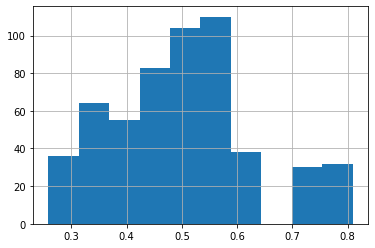

In [93]:
dat_mean['singlepass','rank'].hist()

In [94]:
dat_mean.iloc[dat_mean['multipass','rank'].argmax(),:] # Always argmax high scores have become high importances, low ranks have become high importances.

singlepass  rank     0.809256
            score    0.755719
multipass   rank     0.571429
            score    0.300666
Name: (t850_nhblock, 21, -24, -3, 2, spatcov), dtype: float64

The conclusion here is that the importance ranks are very variable from fold to fold. None is consistently high when averaged over the folds. 

In [2]:
# Read in the clustid netcdfvariable/timescale combinations
def read_clustid_map(basepath: Path, variable: str, timeagg: int, lag: int) -> xr.DataArray:
    datapath = basepath / '.'.join([variable,str(timeagg),'corr','nc']) # e.g. clustertest_roll_spearman_varalpha/sst_nhplus.31.corr.nc 
    r = Reader(datapath = datapath, ncvarname = 'clustid')
    arr = r.read(into_shared = False, decode_lag = False)
    arr = xr.DataArray(arr, coords = r.coords, dims = r.dims, name = 'clustid')
    return arr.sel(lag = lag)

def fill_with_importance(clustid_map: xr.DataArray, imp_series : pd.Series) -> xr.DataArray:
    """
    Another function for matching the importance alpha to clustids of one field
    the imp series should contain this variable only
    Preferable this is scaled (0-1) with the other variables
    """
    clustids_series = imp_series.index.get_level_values('clustid') # Strings?
    clustids_map = np.unique(clustid_map)
    assert len(clustids_series) == len(clustids_map[~np.isnan(clustids_map)]), 'make sure clustids are unique in your imp_series selection'
    for clustid in clustids_series:
        clustid_map = clustid_map.where(clustid_map != float(clustid), other = imp_series.iloc[clustids_series == clustid][0])
    return clustid_map

def plot_importance_per_sep(selection: pd.Series, basepath: Path):
    """
    plotting the importance of all variable / timeagg combinations present in that Series for a single separation 
    by displaying the geographical clusters
    """
    variables = np.unique(selection.index.get_level_values('variable')).tolist()
    timeaggs = np.unique(selection.index.get_level_values('timeagg')).astype('int')
    timeaggs.sort()
    timeaggs = timeaggs[::-1].tolist() # Reversed because of slow to fast. Actually reversed is more meaningful for separation
    
    fig, axes = plt.subplots(nrows = len(variables), ncols = len(timeaggs), squeeze=False, figsize = (3*len(timeaggs),4*len(variables)))
    
    for variable in variables:
        for timeagg in timeaggs:
            try:
                subset = selection.loc[(variable, str(timeagg))]
                lag = np.unique(subset.index.get_level_values('lag'))[0] # Is unique because we are working with a selection from one separation. Each timeagg has a unique lag
                clust_map = read_clustid_map(basepath = basepath, variable = variable, timeagg = timeagg, lag = int(lag))
                clust_map = fill_with_importance(clust_map,imp_series=subset)
                ax = axes[variables.index(variable),timeaggs.index(timeagg)]
                clust_map.plot(ax = ax,vmin = selection.min(), vmax = selection.max())
            except KeyError: # This variable combination does not exist. No significant clusters are present
                pass 

def plot_importance_per_var(selection: pd.Series, basepath: Path):
    """
    plotting the importance of all timeagg / separation combinations present in that Series for a single variable
    by displaying the geographical clusters
    """
    variable = np.unique(selection.index.get_level_values('variable'))[0] # Should be unique, perhaps assert statement
    separations = np.unique(selection.index.get_level_values('separation')).astype('int')
    separations.sort()
    separations = separations.tolist()
    
    timeaggs = np.unique(selection.index.get_level_values('timeagg')).astype('int')
    timeaggs.sort()
    timeaggs = timeaggs.tolist()
    
    fig, axes = plt.subplots(nrows = len(timeaggs), ncols = len(separations), squeeze=False, figsize = (3*len(separations),4*len(timeaggs)))
    for separation in separations:
        for timeagg in timeaggs:
            subset = selection.loc[(slice(None),variable, str(timeagg), slice(None), str(separation))]
            ax = axes[timeaggs.index(timeagg), separations.index(separation)]
            ax.set_axis_off()
            if not subset.empty: # If empty then there are no clusters for this separation / timeagg.
                lag = np.unique(subset.index.get_level_values('lag'))[0] # Is unique because we are working with a selection from one separation. Each timeagg has a unique lag
                clust_map = read_clustid_map(basepath = basepath, variable = variable, timeagg = timeagg, lag = int(lag))
                clust_map = fill_with_importance(clust_map,imp_series=subset)
                ax.pcolormesh(clust_map,vmin = selection.min(), vmax = selection.max())
            ax.set_title(f'{timeagg},{separation}')

# single function for a plot on a basemap?

NameError: name 'Path' is not defined

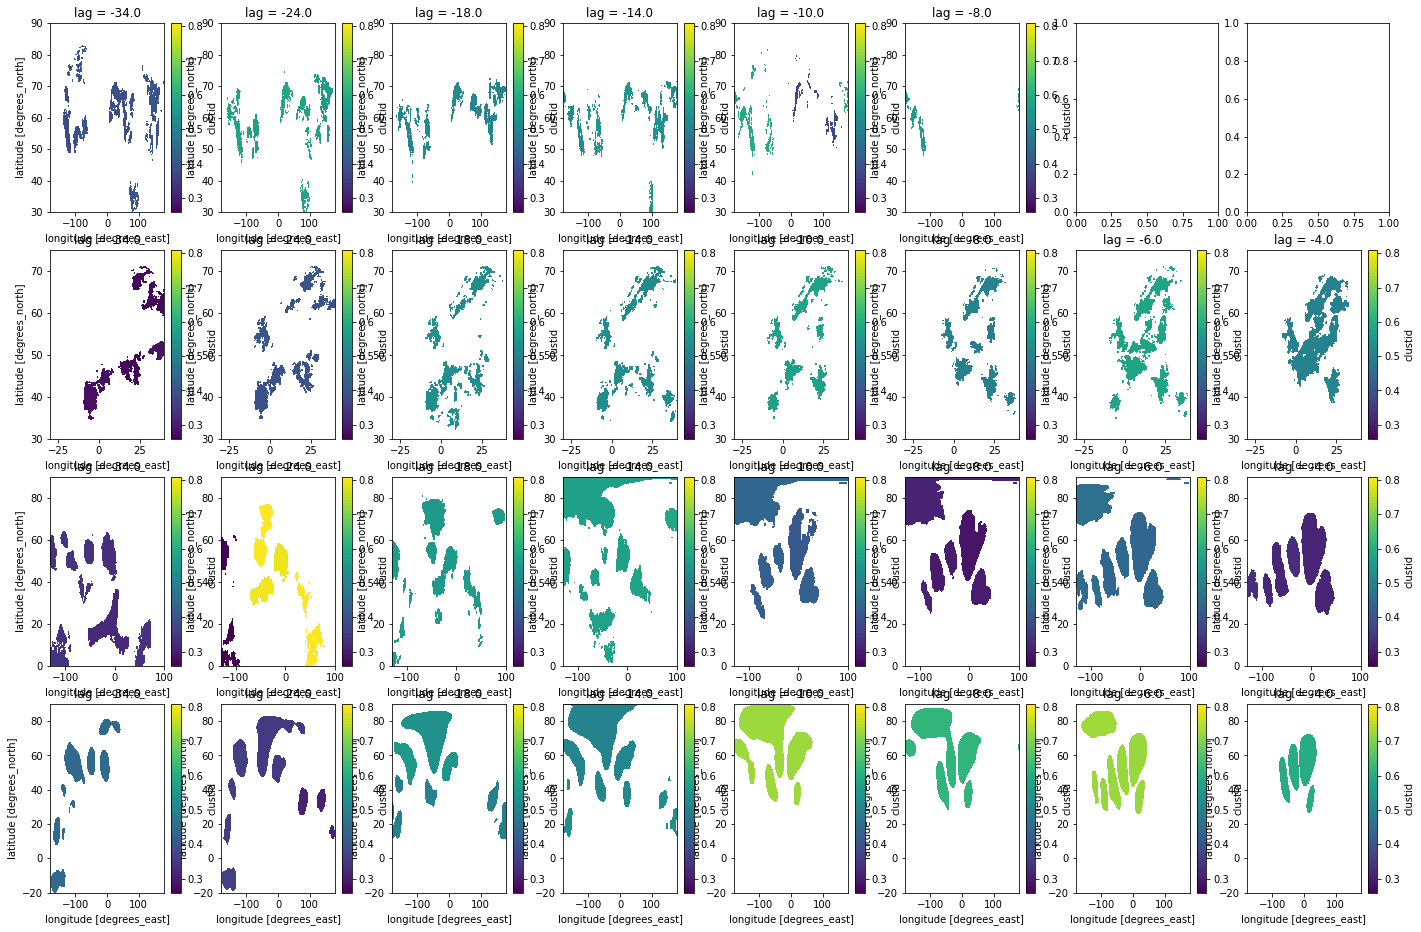

In [145]:
selection = dat_mean.loc[(['t850_nhblock','z300_nhnorm','swvl13_europe','snowc_nhmin'],slice(None),slice(None),slice(None),slice(None),'spatcov'),('singlepass','rank')].sort_index()
plot_importance_per_sep(selection, basepath = Path('/scistor/ivm/jsn295/clustertest_roll_spearman_varalpha/'))

### Going through all the timeagg/ separation combinations.
Contains the importances of random forests with params: (max_depth = 500, n_estimators = 200, min_samples_split = 70, max_features = 0.3) using the clustered predictors 'clustertest_roll_spearman_varalpha'. They are probably overfitting.

In [3]:
basepath = Path('/scistor/ivm/jsn295/importance')

In [4]:
total = []
keys = []
for i in basepath.glob('*/*/*.parquet'):
    # You might want to scale over multiple separations, though this might lead to a problem with scores /folds that are very different. Or do it per separation (then importances are not relative to each other)
    resptimeagg, separation = i.parts[len(basepath.parts):(len(basepath.parts)+2)]
    dat_onesep = pd.read_parquet(i)
    total.append(dat_onesep)
    keys.append((resptimeagg,separation))
total = pd.concat(total, axis = 0, keys = keys) # Now separation is in there twice
total.index.names = ['respagg','separation2'] + total.index.names[2:]
total.index = total.index.droplevel('separation2')
total = total.reorder_levels([1,0] + list(range(2,8))) # To make sure that [1:] selects all except fold

In [5]:
total

singlepass  \
                                                                        rank   
fold respagg variable      timeagg lag separation clustid metric               
0    1       swvl4_europe  15      -20 -5         1       spatcov          0   
                                                  2       spatcov          1   
             t850_nhblock  1       -6  -5         3       mean             2   
                           5       -10 -5         3       mean             3   
             swvl4_europe  11      -16 -5         2       mean             4   
...                                                                      ...   
9    3       transp_europe 7       -10 -3         1       mean           547   
                           11      -14 -3         0       mean           548   
                                                          spatcov        549   
             t850_nhblock  3       -6  -3         5       mean           550   
                           21      -24 -3         5       mean           551   

                                                                             \
                                                                      score   
fold respagg variable      timeagg lag separation clustid metric              
0    1       swvl4_europe  15      -20 -5         1       spatcov  1.651840   
                                                  2       spatcov  1.651840   
             t850_nhblock  1       -6  -5         3       mean     1.651840   
                           5       -10 -5         3       mean     1.651840   
             swvl4_europe  11      -16 -5         2       mean     1.651840   
...                                                                     ...   
9    3       transp_europe 7       -10 -3         1       mean     1.343431   
                           11      -14 -3         0       mean     1.343103   
                                                          spatcov  1.343102   
             t850_nhblock  3       -6  -3         5       mean     1.342567   
                           21      -24 -3         5       mean     1.342487   

                                                                  multipass  \
                                                                       rank   
fold respagg variable      timeagg lag separation clustid metric              
0    1       swvl4_europe  15      -20 -5         1       spatcov       0.0   
                                                  2       spatcov       NaN   
             t850_nhblock  1       -6  -5         3       mean          NaN   
                           5       -10 -5         3       mean          NaN   
             swvl4_europe  11      -16 -5         2       mean          NaN   
...                                                                     ...   
9    3       transp_europe 7       -10 -3         1       mean          NaN   
                           11      -14 -3         0       mean          NaN   
                                                          spatcov       NaN   
             t850_nhblock  3       -6  -3         5       mean          NaN   
                           21      -24 -3         5       mean          NaN   

                                                                            
                                                                     score  
fold respagg variable      timeagg lag separation clustid metric            
0    1       swvl4_europe  15      -20 -5         1       spatcov  1.65184  
                                                  2       spatcov      NaN  
             t850_nhblock  1       -6  -5         3       mean         NaN  
                           5       -10 -5         3       mean         NaN  
             swvl4_europe  11      -16 -5         2       mean         NaN  
...                                                                    ...  
9    3       transp_europe 7       -10

In [10]:
scale_per_fold = total.groupby(['respagg','fold']).apply(scale_scores_ranks_to_importance, **{'fill_multipass':True}).groupby(total.index.names[1:]).mean()

In [46]:
scale_per_fold_sep = total.groupby(['respagg','fold','separation']).apply(scale_scores_ranks_to_importance, **{'fill_multipass':True}).groupby(total.index.names[1:]).mean()

In [29]:
print(scale_per_fold.loc[(slice(None),slice(None),slice(None),'-3'),:].iloc[scale_per_fold.loc[(slice(None),slice(None),slice(None),'-3'),('singlepass','score')].argmax()])
print(scale_per_fold_sep.loc[(slice(None),slice(None),slice(None),'-3'),:].iloc[scale_per_fold_sep.loc[(slice(None),slice(None),slice(None),'-3'),('singlepass','score')].argmax()])
# You end up with different values

singlepass  rank     0.696650
            score    0.400998
multipass   rank     0.000000
            score    0.000000
Name: (21, snowc_nhmin, 3, -3, 0, 0, mean), dtype: float64
singlepass  rank     0.731641
            score    0.644892
multipass   rank     0.100000
            score    0.015266
Name: (7, snowc_nhmin, 3, -3, 0, 0, mean), dtype: float64


In [26]:
scale_per_fold.mean() # scale per fold one would be most useful for the plots I like to make. Importance flow over separations.

singlepass  rank     0.590652
            score    0.582508
multipass   rank     0.008490
            score    0.010390
dtype: float64

In [27]:
scale_per_fold_sep.mean() # lower scores?

singlepass  rank     0.500000
            score    0.496165
multipass   rank     0.008490
            score    0.007780
dtype: float64

In [28]:
scale_per_fold

singlepass  \
                                                                  rank   
respagg variable     timeagg lag separation clustid metric               
1       siconc_nhmin 11      -11 0          0       mean      0.556281   
                                                    spatcov   0.596315   
                                            1       mean      0.319095   
                                                    spatcov   0.547404   
                             -12 -1         0       mean      0.419933   
...                                                                ...   
7       z500_europe  7       -8  -1         0       spatcov   0.494975   
                                            1       mean      0.422446   
                                                    spatcov   0.550586   
                                            2       mean      0.478727   
                                                    spatcov   0.530988   

                                                                       \
                                                                score   
respagg variable     timeagg lag separation clustid metric              
1       siconc_nhmin 11      -11 0          0       mean     0.005649   
                                                    spatcov  0.006006   
                                            1       mean     0.004142   
                                                    spatcov  0.005537   
                             -12 -1         0       mean     0.337482   
...                                                               ...   
7       z500_europe  7       -8  -1         0       spatcov  0.320372   
                                            1       mean     0.318985   
                                                    spatcov  0.323614   
                                            2       mean     0.318923   
                                                    spatcov  0.322659   

                                                            multipass        
                                                                 rank score  
respagg variable     timeagg lag separation clustid metric                   
1       siconc_nhmin 11      -11 0          0       mean     0.000000   0.0  
                                                    spatcov  0.000000   0.0  
                                            1       mean     0.028571   0.0  
                                                    spatcov  0.000000   0.0  
                             -12 -1         0       mean     0.000000   0.0  
...                                                               ...   ...  
7       z500_europe  7       -8  -1         0       spatcov  0.000000   0.0  
                                            1       mean     0.000000   0.0  
                                                    spatcov  0.000000   0.0  
                                            2       mean     0.000000   0.0  
                                                    spatcov  0.000000   0.0  

[32036 rows x 4 columns]

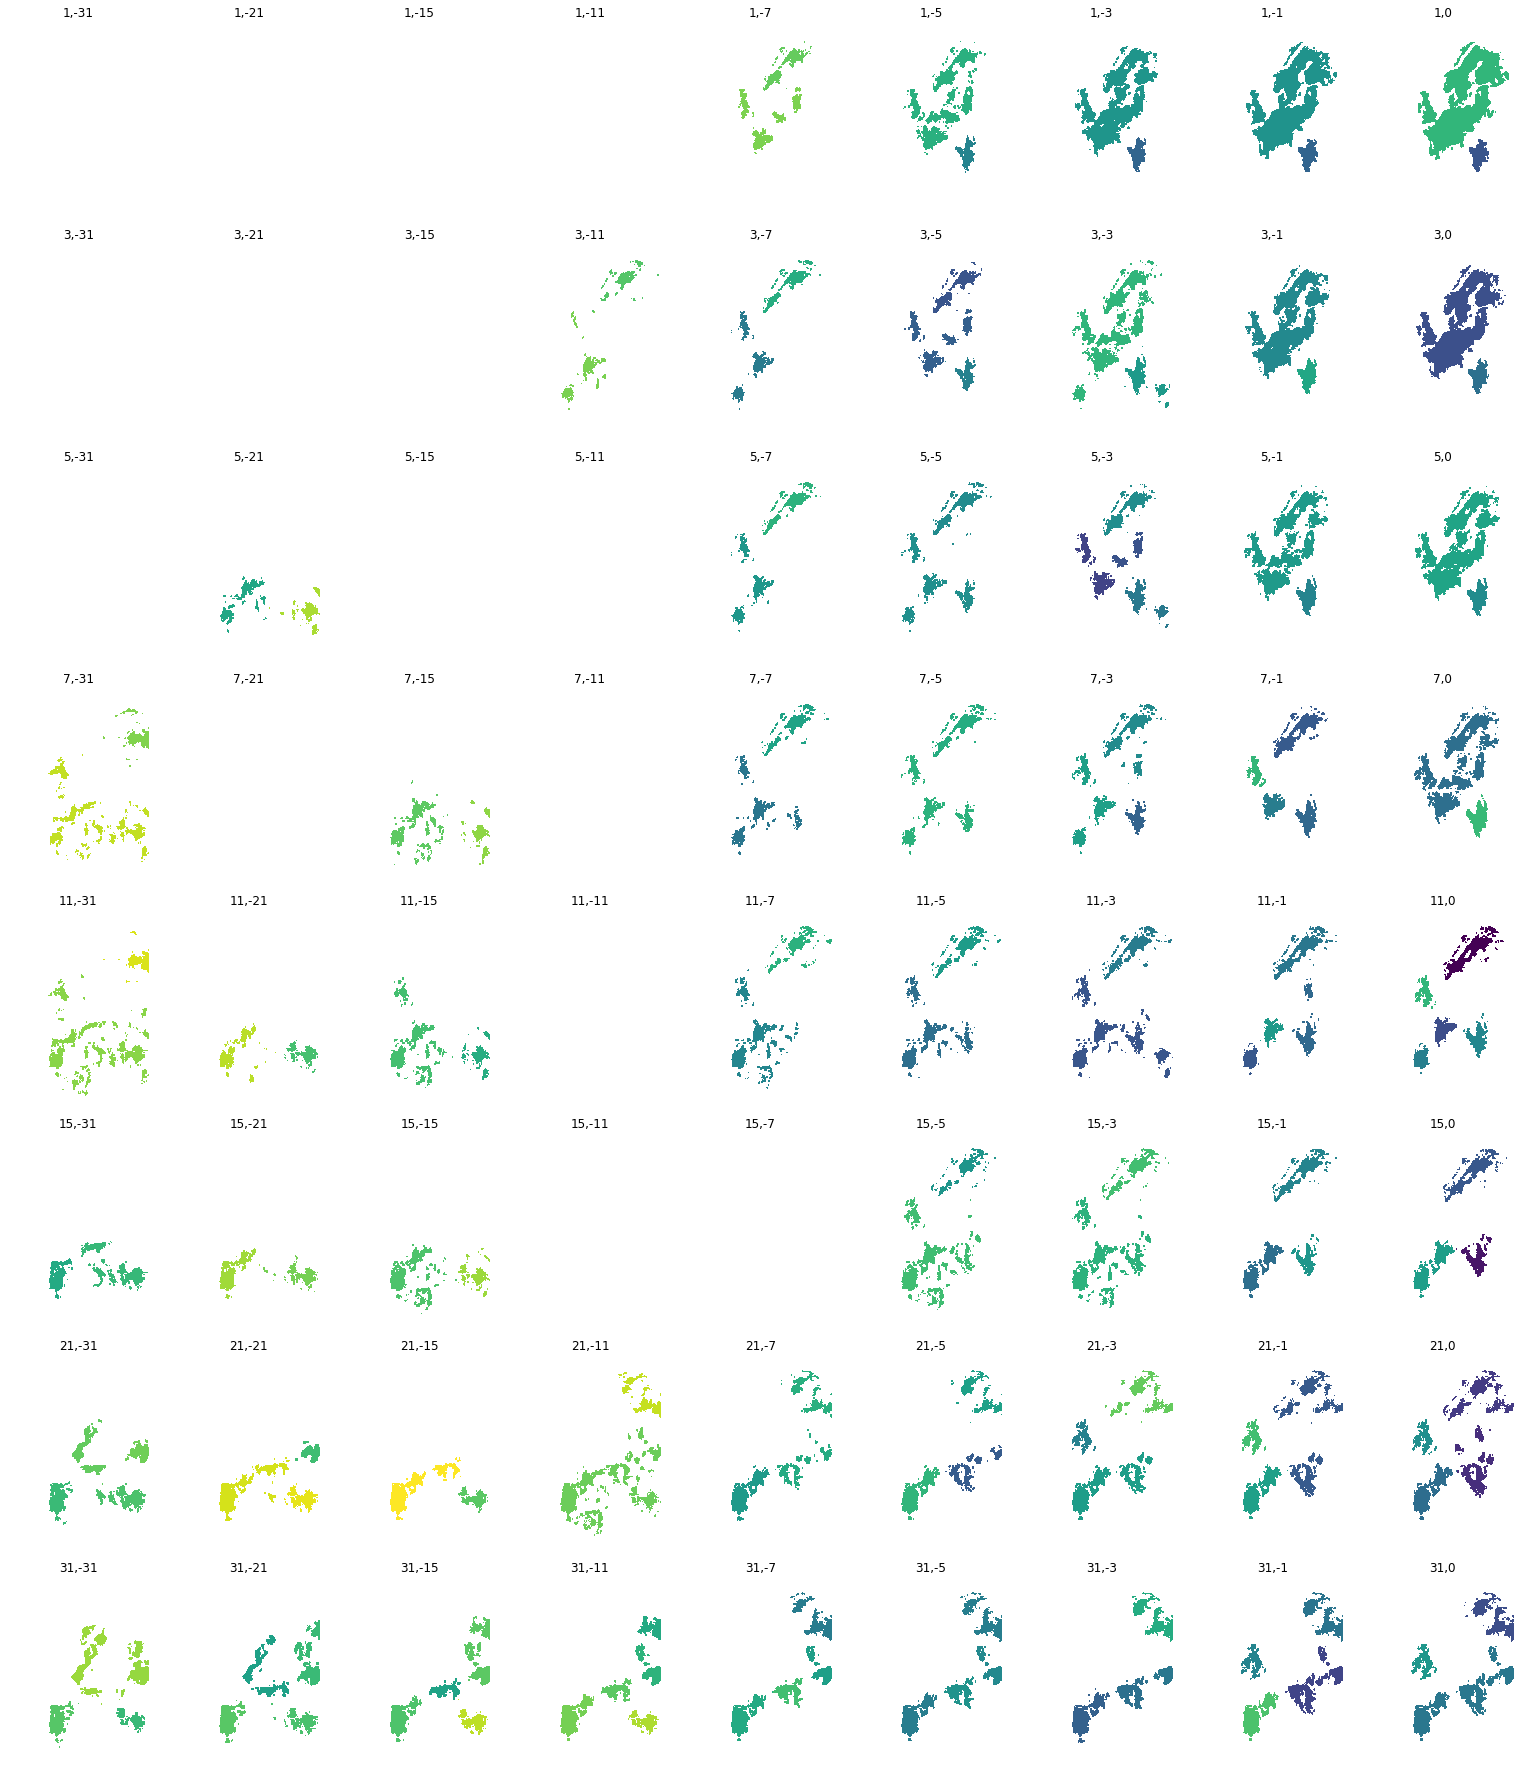

In [54]:
#plot_importance_per_var(scale_per_fold.loc[(['swvl13_europe'],slice(None),slice(None),slice(None),slice(None), 'spatcov'),('singlepass','rank')], basepath = Path('/scistor/ivm/jsn295/clustertest_roll_spearman_varalpha/'))
# Lets take on a subseasonal predictand with respagg = 11
plot_importance_per_var(scale_per_fold.loc[('11','swvl13_europe',slice(None),slice(None),slice(None),slice(None), 'spatcov'),('singlepass','rank')], basepath = Path('/scistor/ivm/jsn295/clustertest_roll_spearman_varalpha/'))

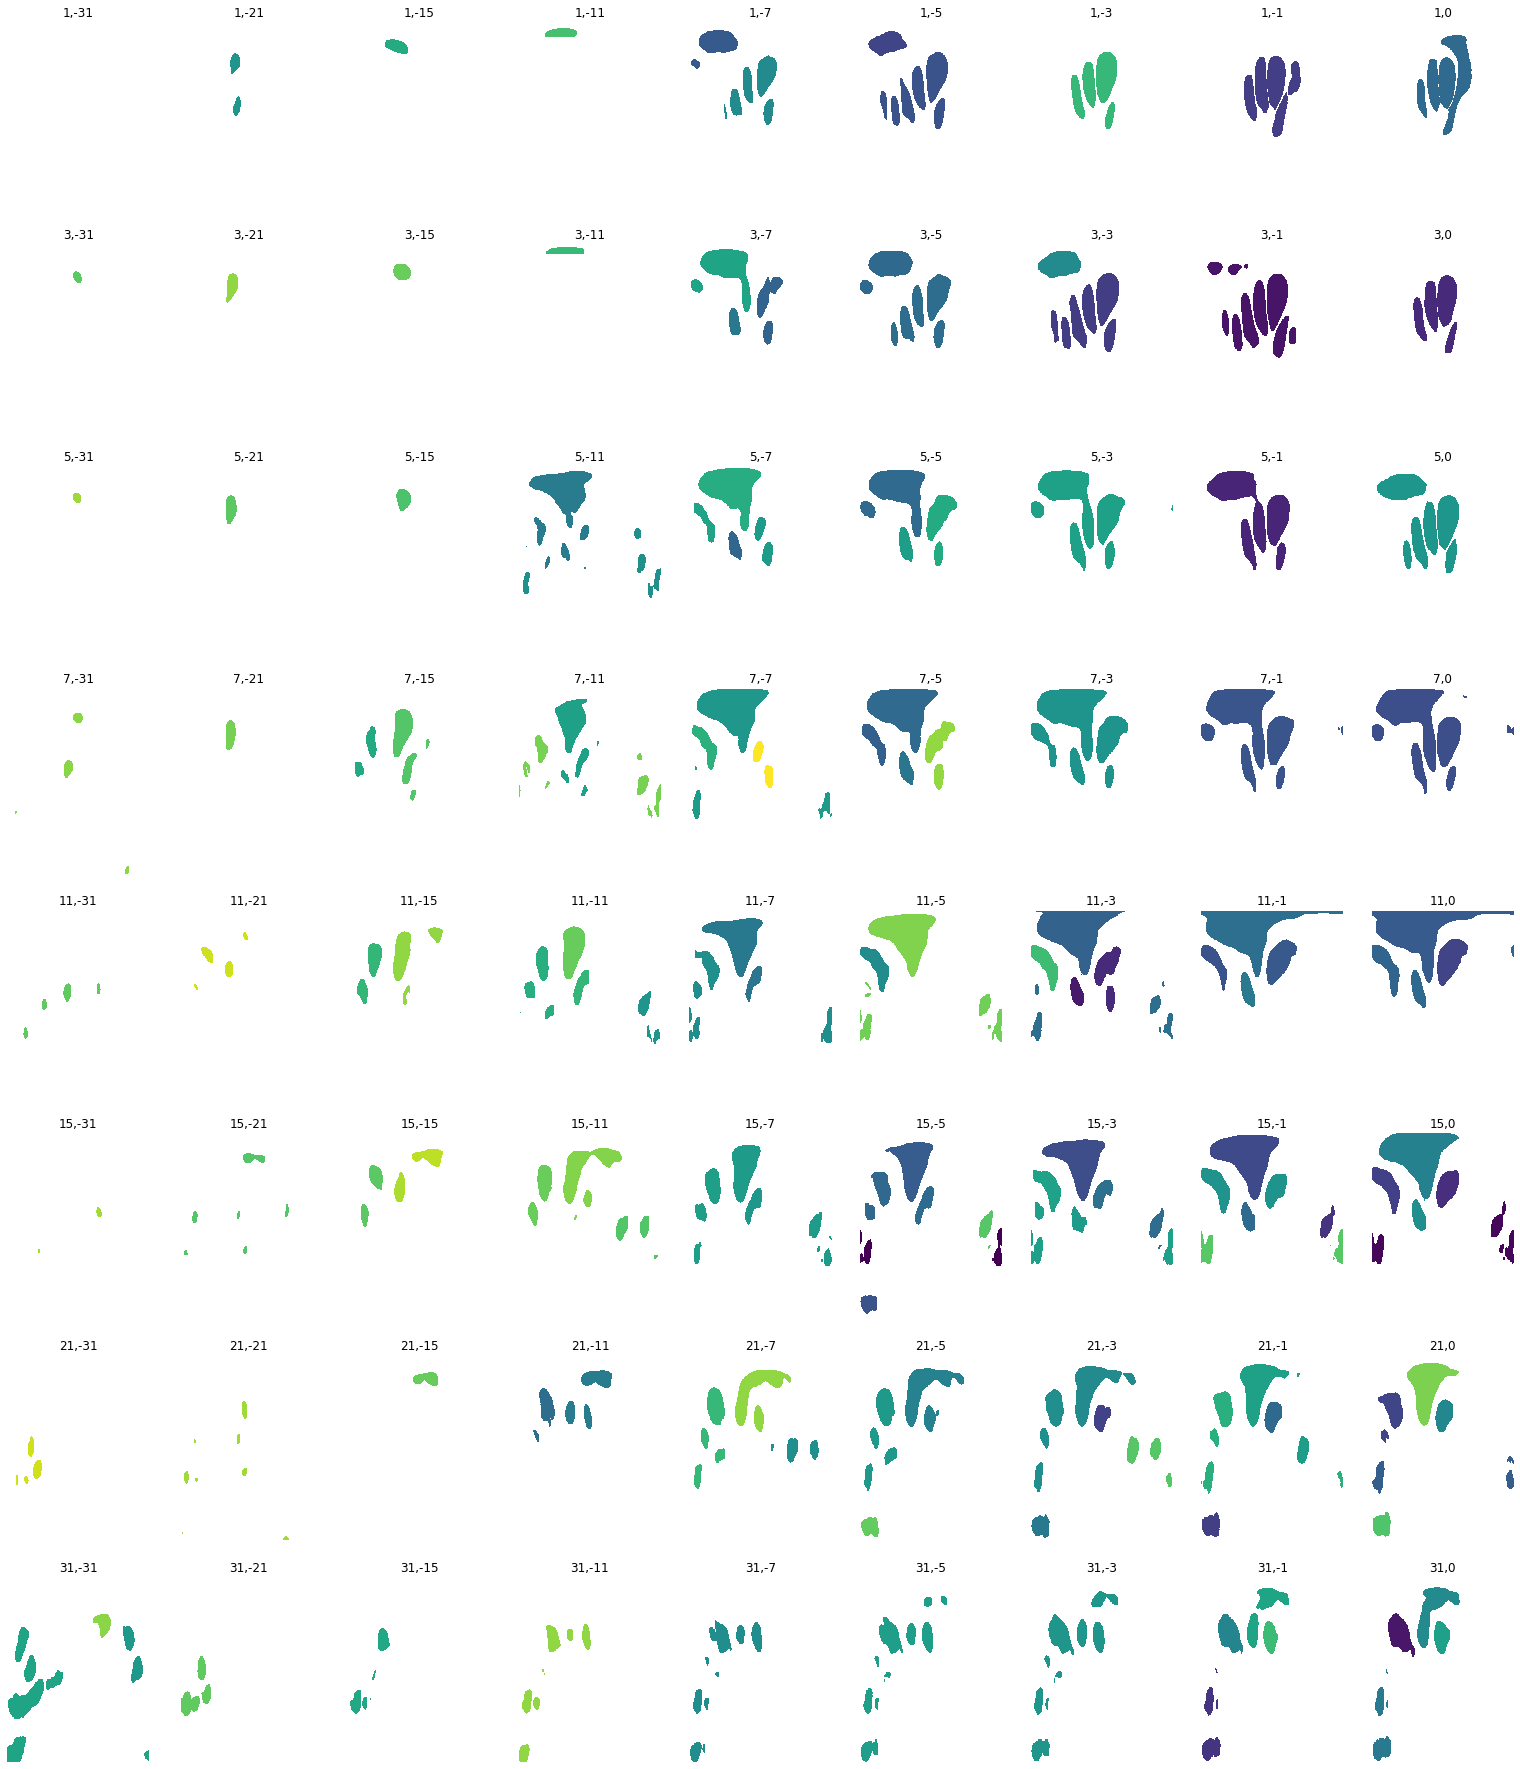

In [55]:
plot_importance_per_var(scale_per_fold.loc[('11','z300_nhnorm',slice(None),slice(None),slice(None),slice(None), 'spatcov'),('singlepass','rank')], basepath = Path('/scistor/ivm/jsn295/clustertest_roll_spearman_varalpha/'))

### respagg timescale visualization
Above we have visualized importance for a single response aggregation (i.e. forecasting problem) to see whether at a bigger separation other regions and timescales become important.
Now we want to see only whether the important timescales change with separation and with other forecasting settings (pooling all clusters on one pile).

respagg timeagg singlepass  \
                                                                  rank   
variable     lag separation clustid metric                               
siconc_nhmin -11 0          0       mean          1      11   0.556281   
                                    spatcov       1      11   0.596315   
                            1       mean          1      11   0.319095   
                                    spatcov       1      11   0.547404   
             -12 -1         0       mean          1      11   0.419933   
...                                             ...     ...        ...   
z500_europe  -8  -1         0       spatcov       7       7   0.494975   
                            1       mean          7       7   0.422446   
                                    spatcov       7       7   0.550586   
                            2       mean          7       7   0.478727   
                                    spatcov       7       7   0.530988   

                                                      multipass        
                                                score      rank score  
variable     lag separation clustid metric                             
siconc_nhmin -11 0          0       mean     0.005649  0.000000   0.0  
                                    spatcov  0.006006  0.000000   0.0  
                            1       mean     0.004142  0.028571   0.0  
                                    spatcov  0.005537  0.000000   0.0  
             -12 -1         0       mean     0.337482  0.000000   0.0  
...                                               ...       ...   ...  
z500_europe  -8  -1         0       spatcov  0.320372  0.000000   0.0  
                            1       mean     0.318985  0.000000   0.0  
                                    spatcov  0.323614  0.000000   0.0  
                            2       mean     0.318923  0.000000   0.0  
                                    spatcov  0.322659  0.000000   0.0  

[32036 rows x 6 columns]

In [81]:
def respagg_timescale_plot(df, variables = ['z300_nhnorm'], metric = 'spatcov', imp_measure = ('singlepass','score'), groupclustid_func = None, scaler = 0.3):
    # Let's first graph everything according to spatcov
    fullframe = df.reset_index(['respagg','timeagg'])
    fullframe['respagg'] = pd.to_numeric(fullframe['respagg'])
    fullframe['timeagg'] = pd.to_numeric(fullframe['timeagg'])
    fullframe.index.set_levels(pd.to_numeric(fullframe.index.levels[fullframe.index.names.index('separation')]), 'separation', inplace = True)
    separations = np.sort(fullframe.index.get_level_values('separation').unique())

    fig,axes = plt.subplots(ncols = len(separations), nrows = len(variables), squeeze = False, figsize = (20,3.5*len(variables)),sharey= True,sharex = True)
    for i,variable in enumerate(variables):
        for j,separation in enumerate(separations): # Will be columns
            plotframe = fullframe.loc[(variable,slice(None),separation,slice(None),metric),:]
            if not groupclustid_func is None:
                f = getattr(plotframe.groupby(['respagg','timeagg']), groupclustid_func)
                plotframe = f().reset_index(['respagg','timeagg']) # To discount the number of clust contributing to high alpha
            # Only one importance score
            rgba_colors = np.zeros((len(plotframe),4),dtype = 'float64')
            rgba_colors[:,0] = 1
            rgba_colors[:,-1] = plotframe.loc[:,imp_measure] * scaler 
            plotframe.plot.scatter(x = 'respagg', y = 'timeagg', ax = axes[i,j], color =rgba_colors)
            axes[i,j].set_ylabel('important timeagg')
            axes[i,j].legend()
            axes[i,j].set_title(f'sep: {separation}, {variable[:4]}')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

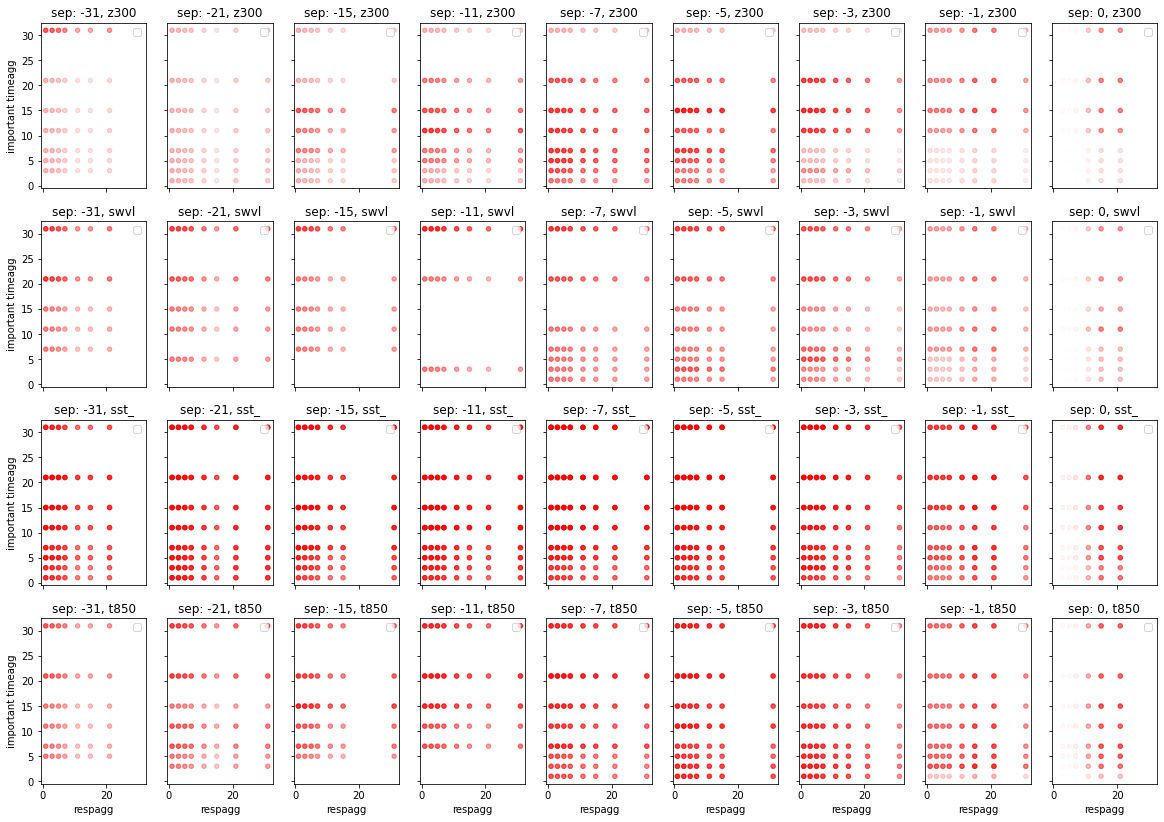

In [77]:
respagg_timescale_plot(scale_per_fold, variables = ['z300_nhnorm','swvl13_europe','sst_nhplus','t850_nhblock'])

Interesting visualization. First of all the it should be noted that actually the amount of clusters (low alphas plotted on top of each other) could determine the brightness. This might explain some of the horizontal-ness of the importance (regardless of the respagg there can be more clusters for a certain timeagg / separation) Therefore we do another variety later with a groupclustid_func.

Also note that scaling over the seps discounts the lower seps (there are less single important variables there for all respaggs). For instance for the respagg < 10 at sep is 0 there is hardly any importance of t850. However, for the larger separations these t850 become important. These things are much more uniform below.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

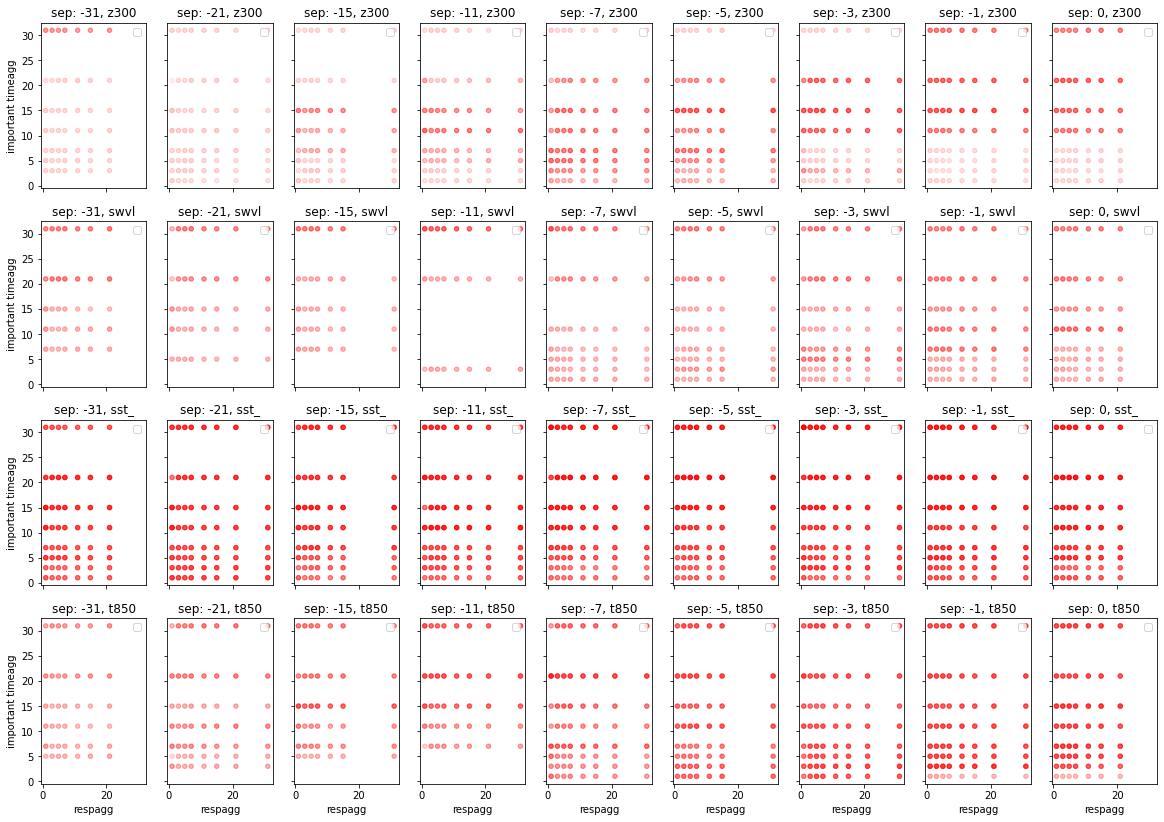

In [78]:
respagg_timescale_plot(scale_per_fold_sep, variables = ['z300_nhnorm','swvl13_europe','sst_nhplus','t850_nhblock'])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

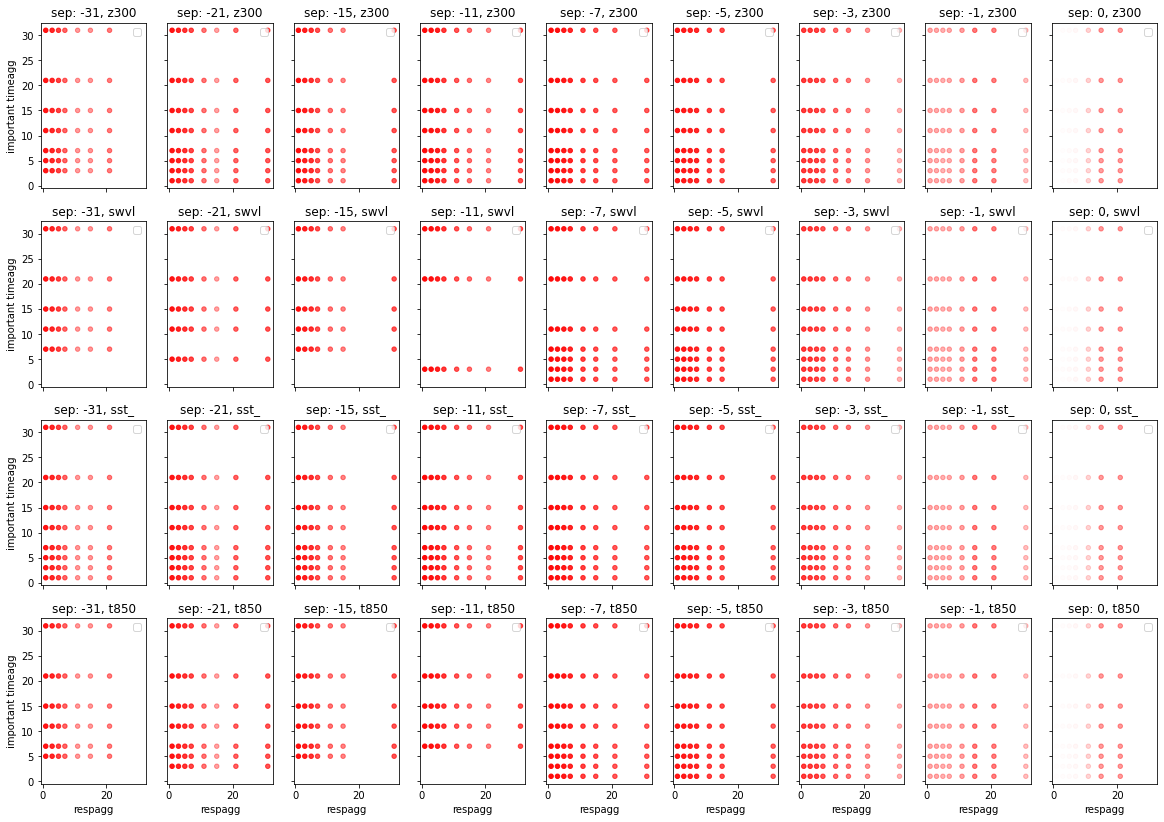

In [82]:
respagg_timescale_plot(scale_per_fold, variables = ['z300_nhnorm','swvl13_europe','sst_nhplus','t850_nhblock'], groupclustid_func='max', scaler = 1)

This makes the timeaggs all more equal to each other as more clusters for that timeagg do not count. Accross variables this looks very homogenous, and it is hard to distinguish the important timescales within a varaible. So we might want to scale per fold, per respagg, per variable per seps and over timeaggs.

In [88]:
superscaled = total.groupby(['respagg','fold','separation','variable']).apply(scale_scores_ranks_to_importance, **{'fill_multipass':True}).groupby(total.index.names[1:]).mean()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

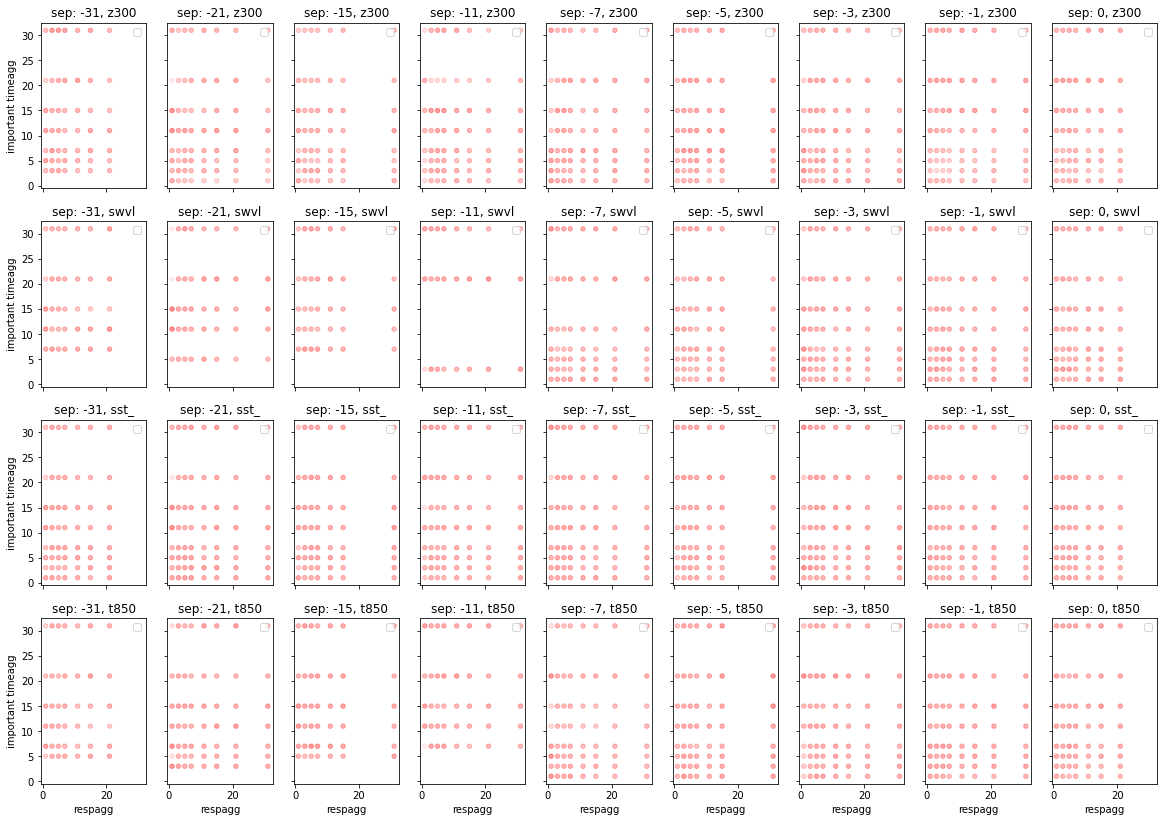

In [93]:
respagg_timescale_plot(superscaled, variables = ['z300_nhnorm','swvl13_europe','sst_nhplus','t850_nhblock'], groupclustid_func='max', scaler = 0.5)

So this is the one that in priciple would show the greatest distinction between timescales, within a variable and within a separation. I think that the absence of clear differences is a sign of poor quality fits and permutation importances.

### Skill (not importance) with resptimeagg
Select the one with the lowest absolute score, this is assigned to the variable that degrades the model the least, and therefore the most skillful prediciton.

In [110]:
best = total.loc[:,('singlepass','score')].groupby(['fold','respagg','separation']).min()
best.index.set_levels(pd.to_numeric(best.index.levels[best.index.names.index('respagg')]), 'respagg', inplace = True)
best.index.set_levels(pd.to_numeric(best.index.levels[best.index.names.index('separation')]), 'separation', inplace = True)
best = best.unstack(0)

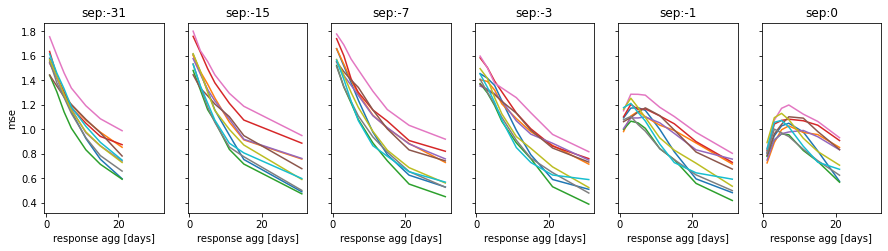

In [120]:
separations = [-31, -15, -7, -3, -1, 0]
fix, axes = plt.subplots(ncols = len(separations), sharey = True, sharex = True, figsize = (15,3.5), squeeze = False)
for i, separation in enumerate(separations):
    ax = axes[0,i]
    plotframe = best.loc[(slice(None),separation),:].sort_index()
    plotframe.index = plotframe.index.droplevel('separation')
    ax.plot(plotframe.index, plotframe)
    ax.set_title(f'sep:{separation}')
    ax.set_xlabel('response agg [days]')
    if i == 0:
        ax.set_ylabel('mse')